In [1]:
# Load libraries for analysis and visualization
import pandas as pd # collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import numpy as np  # foundational package for scientific computing
import re           # Regular expression operations
import matplotlib.pyplot as plt # Collection of functions for scientific and publication-ready visualization
import lightgbm as lgb
%matplotlib inline

import plotly.offline as py     # Open source library for composing, editing, and sharing interactive data visualization 
from matplotlib import pyplot
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter

# Machine learning libraries
import sys
sys.path.append('/Users/minjielu/anaconda3/envs/python/lib/python3.5/site-packages')

import xgboost as xgb  # Implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning
import seaborn as sns  # Visualization library based on matplotlib, provides interface for drawing attractive statistical graphics

import sklearn         # Collection of machine learning algorithms
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier)
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, precision_recall_curve, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read datasets
train = pd.read_csv('../train.csv')
# test = pd.read_csv('./test.csv')
test = []

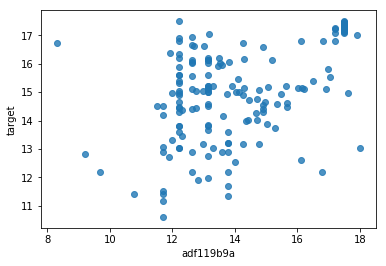

In [3]:
# Stripplot of targets versus values of a chosen column before data cleaning
column = 'adf119b9a'
sns.regplot(x=np.log1p(train.loc[train[column] != 0,column]),y=np.log1p(train.loc[train[column] != 0,'target']),fit_reg=False)
#plt.xticks(np.arange(min(np.log1p(train.loc[train['9fc776466'] != 0,'adf119b9a'])), max(np.log1p(train.loc[train['adf119b9a'] != 0,'adf119b9a']))+1, 1.0))

In [4]:
# Remove ranges of values with large standard deviation
for column in train.columns:
    if (column != 'ID') and (column != 'target'):
        if train[train[column] != 0].shape[0] < 20: # Continue if one column has less than 20 nonzero values
            continue
        tmpdf = np.log1p(train.loc[train[column] != 0, [column,'target']])
        cuts = np.ceil(tmpdf[column].max()-tmpdf[column].min()) # Bins are arithmetic series with difference 1
        _,bins = pd.cut(tmpdf[column],cuts,retbins=True)
        # Calculate standard deviation of each range
        target_std = []
        for ind in np.arange(len(bins)-1):
            target_std.append(tmpdf.loc[(tmpdf[column] >= bins[ind]) & (tmpdf[column] < bins[ind+1]),'target'].std())
            #print(tmpdf.loc[(tmpdf[column] >= bins[ind]) & (tmpdf[column] < bins[ind+1]),'target'].std())
            #print(tmpdf.loc[(tmpdf[column] >= bins[ind]) & (tmpdf[column] < bins[ind+1]),'target'].shape[0])
        target_std.sort()
        target_std = pd.Series(target_std,name='std')
        target_std = target_std.dropna()
        # Keep five ranges that have smallest deviations
        if target_std.shape[0] < 5: # Continue if there are less than 5 ranges
            continue
        valve = target_std.iloc[4] # Ranges with deviations larger than valve will be cleaned
        for ind in np.arange(len(bins)-1):
            if tmpdf.loc[(tmpdf[column] >= bins[ind]) & (tmpdf[column] < bins[ind+1]),'target'].std() > valve:
                train.loc[(np.log1p(train[column]) >= bins[ind]) & (np.log1p(train[column]) <= bins[ind+1]),column] = 0

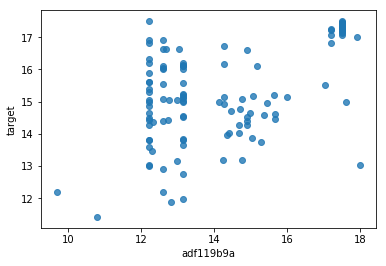

In [5]:
# Stripplot of targets versus values of a chosen column before data cleaning
column = 'adf119b9a'
sns.regplot(x=np.log1p(train.loc[train[column] != 0,column]),y=np.log1p(train.loc[train[column] != 0,'target']),fit_reg=False)
#plt.xticks(np.arange(min(np.log1p(train.loc[train['9fc776466'] != 0,'adf119b9a'])), max(np.log1p(train.loc[train['adf119b9a'] != 0,'adf119b9a']))+1, 1.0))

In [19]:
#train_y = train['target']
#train_x = train.loc[:,(train.columns !='ID') & (train.columns != 'target')].loc[:,((nonzero_corr['target'] > 0) | (nonzero_corr['target'] < 0)) & (nonzero_corr['nonzero_cnt'] > 200)]
#test_x = test.loc[:,(test.columns != 'ID') & (test.columns != 'target')].loc[:,((nonzero_corr['target'] > 0) | (nonzero_corr['target'] < 0)) & (nonzero_corr['nonzero_cnt'] > 200)]
#train_x = train.loc[:,((nonzero_corr['target'] > 0) | (nonzero_corr['target'] > )) & (nonzero_corr['nonzero_cnt'] > 200)]

# Get features and target for machine learning models
train_x = train.loc[:,(train.columns != 'ID') & (train.columns != 'target')]
train_y = train['target']
#train_x['target'] = train['target']
#train_x['ID'] = train['ID']
#train_y = train['target_n']
#train_y = train_y.fillna(50)
#train_y

In [21]:
from sklearn.metrics import mean_squared_error
def fit_predict(data, y, test):
    # Create folds
    folds = KFold(n_splits=5, shuffle=True, random_state=1)
    # Init predictions
    #sub_preds = np.zeros(test.shape[0])
    oof_preds = np.zeros(data.shape[0])
    # Convert to lightgbm Dataset
    dtrain = lgb.Dataset(data=data, label=np.log1p(y), free_raw_data=False)
    # Construct dataset so that we can use slice()
    dtrain.construct()
    lgb_params = {
        'objective': 'regression',
        'num_leaves': 58,
        'subsample': 0.6143,
        'colsample_bytree': 0.6453,
        'min_split_gain': np.power(10, -2.5988),
        'reg_alpha': np.power(10, -2.2887),
        'reg_lambda': np.power(10, 1.7570),
        'min_child_weight': np.power(10, -0.1477),
        'verbose': -1,
        'seed': 3,
        'boosting_type': 'gbdt',
        'max_depth': -1,
        'learning_rate': 0.05,
        'metric': 'l2',
    }
    # Run KFold
    for trn_idx, val_idx in folds.split(data):
        # Train lightgbm
        clf = lgb.train(
            params=lgb_params,
            train_set=dtrain.subset(trn_idx),
            valid_sets=dtrain.subset(val_idx),
            num_boost_round=10000, 
            early_stopping_rounds=100,
            verbose_eval=50
        )
        # Predict Out Of Fold and Test targets
        # Using lgb.train, predict will automatically select the best round for prediction
        oof_preds[val_idx] = clf.predict(dtrain.data.iloc[val_idx])
        # sub_preds += clf.predict(test.loc[:,(test.columns != 'ID')]) / folds.n_splits
        # print(sub_preds)
        # Display current fold score
        print(mean_squared_error(np.log1p(y.iloc[val_idx]), 
                                 oof_preds[val_idx]) ** .5)
    # Display Full OOF score (square root of a sum is not the sum of square roots)
    print('Full Out-Of-Fold score : %9.6f' 
          % (mean_squared_error(np.log1p(y), oof_preds) ** .5))

    return oof_preds

In [22]:
#test_1 = test.loc[:,(test.columns != 'ID')]
oof_preds = fit_predict(train_x,train_y,test)

Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 2.01005
[100]	valid_0's l2: 1.90948
[150]	valid_0's l2: 1.91692
[200]	valid_0's l2: 1.93736
Early stopping, best iteration is:
[119]	valid_0's l2: 1.90366
1.3797311213149992
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 2.29819
[100]	valid_0's l2: 2.17461
[150]	valid_0's l2: 2.17041
[200]	valid_0's l2: 2.1717
Early stopping, best iteration is:
[126]	valid_0's l2: 2.16817
1.4724711327905993
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 2.28245
[100]	valid_0's l2: 2.14503
[150]	valid_0's l2: 2.12698
[200]	valid_0's l2: 2.11966
[250]	valid_0's l2: 2.12821
Early stopping, best iteration is:
[197]	valid_0's l2: 2.11834
1.4554501545186587
Training until validation scores don't improve for 100 rounds.
[50]	valid_0's l2: 2.13196
[100]	valid_0's l2: 1.98433
[150]	valid_0's l2: 1.95638
[200]	valid_0's l2: 1.94548
[250]	valid_0's l2: 1.94098
[30

In [23]:
# Generate submission file
customerid = train['ID']
#result = pd.Series(gbm.predict(test_x),name='target')
result = pd.Series(oof_preds,name='target')
result = pd.concat([customerid,result],axis=1)


In [24]:
#min_value = train_y.min()
#result.loc[result['target'] < min_value,'target'] = min_value
result.to_csv('Delete_ranges_with_large_std.csv',index=False)